# Working with Keras: A deep dive

您现在对 Keras 有一些经验——您熟悉序列模型、Dense 层以及用于训练、评估和推理的内置API—— compile()、fit()、evaluate() 和 predict()。您甚至在第3章中学习了如何从 `Layer` 类继承以创建自定义层，以及如何使用 TensorFlow `GradientTape` 实现step-by-step 训练循环。

在接下来的章节中，我们将深入研究计算机视觉、时间序列预测、自然语言处理和生成深度学习。这些复杂的应用需要的不仅仅是  `Sequential` 架构和默认的 `fit()` 循环。因此，让我们先把你变成Keras专家！在这一章中，您将全面了解使用Keras API的关键方法：所有你接下来将会遇到的高级深度学习使用例子。

## 7.1 A spectrum of workflows

Keras API的设计原则为 progressive disclosure of complexity：使入门变得容易，但又使处理高复杂性用例成为可能，只需在每个步骤中进行增量学习。简单的用例应该简单易近人，任意高级的工作流程应该是可能的：无论你想做的事情有多基础和复杂，都应该有一条清晰的路径。一条基于您从更简单的工作流程中学到的各种东西的路径。这意味着您可以从初学者成长为专家，并且仍然使用相同的工具——以不同的方式使用。

因此，没有一种使用Keras的 “real” 方式。相反，Keras提供了从非常简单到非常灵活的 spectrum of workflows。构建Keras模型有不同的方法，以及训练它们的不同方法，以满足不同的需求。由于所有这些工作流程都基于共享API，如 `Layer` 和 `Model`，任何工作流程的组件都可以在任何其他工作流程中使用——它们都可以相互交谈。

## 7.2 Different ways to build Keras models

在Keras中构建模型有三个API（见图7.1）：

- `Sequential` 模型，最容易接触到的API——它基本上是一个Python列表。因此，它仅限于简单的层的堆叠。
- `Functional` API，专注于类似 graph-like 的模型架构。它代表可用性和灵活性之间的一个很好的中点，因此，它是最常用的模型构建API。
- `Model subclassing`，一个低级选项，您可以从头开始编写所有内容。如果你想完全控制每件小事，这是理想的选择。然而，您将无法访问许多内置的Keras功能，并且您将更有可能犯错误。

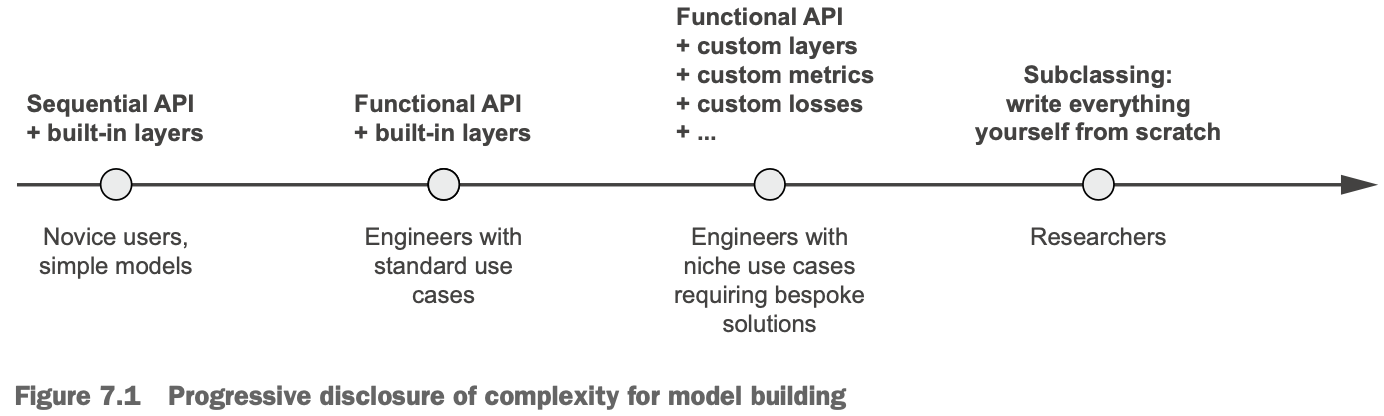

### 7.2.1 The Sequential model

构建 Keras 模型的最简单方法是使用 `Sequential` 模型，您已经知道了。

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

请注意，可以通过 `add()` 方法逐步构建相同的模型，类似于 Python 列表的追加 `append()` 方法。

In [ ]:
model = keras.Sequential()
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

你在第4章中看到，只有第一次调用 layers 时才会被构建(创建它们的权重)。这是因为 layers 权重的形状取决于其输入的形状：在知道输入形状之前，无法创建它们。

因此，在您实际调用某些数据或使用输入形状调用其 `build()` 方法（列表7.4）之前，前面的 `Sequential` 模型没有任何权重（列表7.3）。

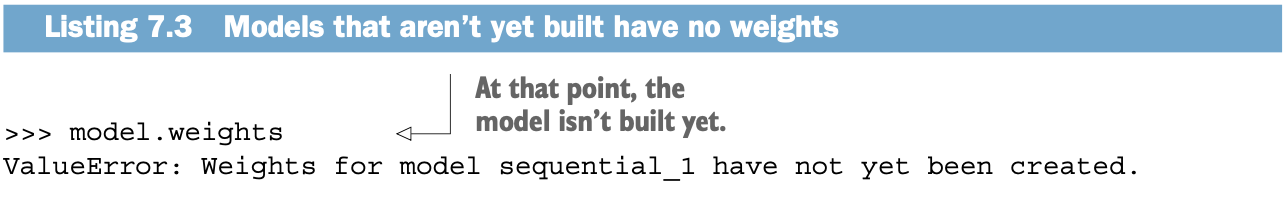

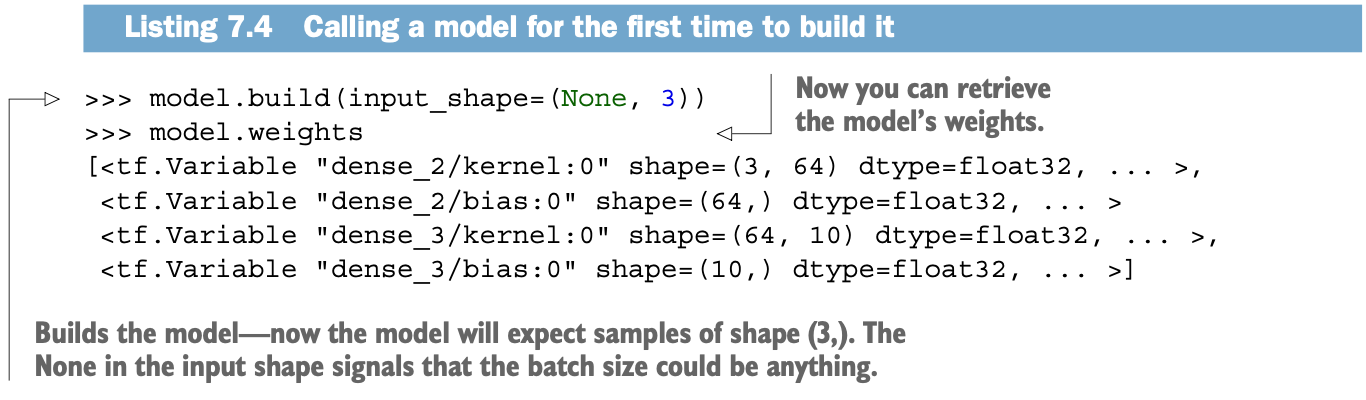

模型构建后，您可以通过 `summary()` 方法显示其内容，该方法可用于调试。

In [ ]:
model.weights

In [ ]:
model.build(input_shape=(None, 3))
model.weights

In [ ]:
model.summary()

如您所见，此模型恰好被命名为 “sequential_1” 。您可以为Keras中的所有内容命名——每个 model、每个 layer。

In [ ]:
model = keras.Sequential(name="my_example_model")
model.add(layers.Dense(64, activation='relu', name='my_first_layer'))
model.add(layers.Dense(10, activation='softmax', name='my_last_layer'))
model.build((None, 3))
model.summary()

在增量构建 `Sequential` 模型时，在添加每个 layer 后，能够打印当前模型的 summary 是有用的。但在模型构建之前，您无法打印 summary！实际上有一种方法可以随时构建您的 `Sequential` ：只需提前声明模型输入的形状。您可以通过输入类来做到这一点。

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation='relu'))

现在，您可以使用 `summary()` 来跟踪模型的输出形状如何变化为：

In [ ]:
model.summary()

In [ ]:
model.add(layers.Dense(10, activation='softmax'))
model.summary()

在处理以复杂方式 transform 输入的层时，这是一个非常常见的调试工作流程, 例如您将在第8章中了解的卷积层。

### 7.2.2 The Functional API

`Sequential` 模型易于使用，但其适用性极其有限：它只能用单个输入和单个输出来表达模型，以顺序方式逐层应用。在实践中，遇到具有多个输入（例如图像及其元数据）、多个输出（您想要预测的数据的不同内容）或非线性拓扑的模型是很常见的。

在这种情况下，您将使用 Functional API 构建模型。这就是你在会遇到的大多数Keras模型。它有趣又强大——感觉就像在玩乐高积木。

**A SIMPLE EXAMPLE**

让我们从简单的事情开始：我们在上一节中使用的堆叠两层。其 Functional API 版本如下所列。



In [ ]:
inputs = keras.Input(shape=(3, ), name='my_input')
features = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10, activation='softmax')(features)
model = keras.Model(inputs=inputs, outputs=outputs)

让我们逐步了解一下这个步骤。

我们从声明 `Input` 开始（请注意，您也可以为这些输入对象命名）：


In [ ]:
inputs = keras.Input(shape=(3, ), name='my_input')

`inputs` 对象保存模型要处理的数据类型和数据形状

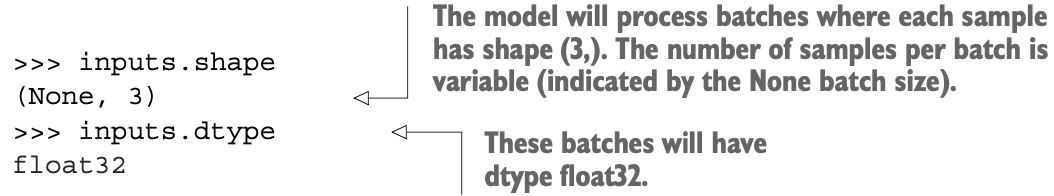

我们称这种对象为 `symbolic tensor`。它不包含任何实际数据，但它编码模型在实际张量的信息。它代表未来的张量数据。

接下来，我们创建了一个 layer，并在输入上调用它：

In [ ]:
features = layers.Dense(64, activation='relu')(inputs)

所有 Keras 层都可以在数据的实际张量和这些符号张量上调用。在后一种情况下，它们返回一个新的符号张量，并更新 shape 和 dtype 信息：

In [ ]:
features.shape

在获得最终输出后，我们通过在 `Model` 构造函数中指定模型的输入和输出来实例化模型：

In [ ]:
outputs = layers.Dense(10, activation='softmax')(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

**MULTI-INPUT, MULTI-OUTPUT MODELS**

与这个玩具模型不同，大多数深度学习模型看起来不像 lists —— 它们看起来像 graphs。例如，它们可能有多个输入或多个输出。正是为这种模型，Functional API真正闪耀着光芒。

假设您正在构建一个系统，按优先级对客户支持票进行排名，并将其路由到适当的部门。您的模型有三个输入：

- 票的标题(text input)
- 票的文字主体(text input）
- 用户的标签(categorical input, 假设是一个独热编码)

我们可以将文本输入编码为1和0数组， 大小为 `vocabulary_size`。

你的模型可能有两个输出：

- 票的优先级分数， 一个 0 到 1 之间的标量 (sigmoid output)
- 处理票的部分(a softmax over the set of departments)

您可以使用Functional API分几行构建此模型。

In [ ]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name='title')
text_body = keras.Input(shape=(vocabulary_size,), name='text_body')
tags = keras.Input(shape=(num_tags, ), name='tags')

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation='relu')(features)

priority = layers.Dense(1, activation='sigmoid', name='priority')(features)
department = layers.Dense(num_departments, activation='softmax', name='department')(features)

model = keras.Model(inputs=[title, text_body, tags],
                    outputs=[priority, department])



Functional API是一种类似于乐高的简单、但非常灵活的定义方式。

**TRAINING A MULTI-INPUT, MULTI-OUTPUT MODEL**

通过调用带有输入和输出数据列表的 `fit()`，您可以以与训练 `Sequential` 模型大致相同的方式训练模型。这些数据列表应与您传递给 `Moedl` 构造函数的输入顺序相同。

In [ ]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer='rmsprop',
              loss=['mean_squared_error', 'categorical_crossentropy'],
              metrics=[['mean_absolute_error'], ['accuracy']])

model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)

model.evaluate([title_data, text_body_data, tags_data],
                 [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])


如果您不想依赖输入顺序（例如，因为您有很多输入或输出），您也可以利用您给输入对象和输出层的名称，通过字典传递数据。

In [ ]:
model.compile(optimizer='rmsprop',
              loss={'priority':'mean_squared_error', 'department':'categorical_crossentropy'},
              metrics={'priority':['mean_absolute_error'], 'department':['accuracy']})
model.fit({'title':title_data, 'text_body':text_body_data, 'tags':tags_data},
          {'priority':priority_data, 'department': department_data},
          epochs=1)
model.evaluate({'title':title_data, 'text_body':text_body_data, 'tags':tags_data},
               {'priority':priority_data, 'department':department_data})
priority_preds, department_preds = model.predict(
    {'title':title_data, 'text_body':text_body_data, 'tags': tags_data})

**THE POWER OF THE FUNCTIONAL API: ACCESS TO LAYER CONNECTIVITY**

Functional 模型是一种显式 graph 数据结构。这使得可以检查 layer 是如何连接的，并重用以前的 graph 节点（即 layer 输出）作为新模型的一部分。它还非常适合大多数研究人员在思考深层神经网络时使用的“mental model”：a graph of layers。这启用了两个重要的用例：模型可视化和特征提取。

让我们可视化一下我们刚刚定义的模型（模型的拓扑）的连通性。您可以使用 `plot_model()` 函数将模型绘制为图（见图 7.2）。

In [ ]:
keras.utils.plot_model(model, "ticket_classifier.png")

您可以将模型中每个 layer 的输入和输出形状添加到此绘图中，这在调试期间可能会有帮助（见图7.3）。

张量形状中的 “None” 表示批量大小：此模型允许任何大小的批量。

访问 layer connectivity 还意味着您可以检查和重用 graph 中的单个节点(layer calls)。 `model.layers` model属性提供了构成模型的 layer 列表，您可以为每个 layer 查询 `layer.input` 和 `layer.output`.

In [ ]:
model.layers

In [ ]:
model.layers[3].input

In [ ]:
model.layers[3].output

这使您可以进行 特征提取，创建重用 其他模型中间特征 的模型。

假设您想在之前的模型中添加另一个输出 —— you want to esti- mate how long a given issue ticket will take to resolve, a kind of difficulty rating。您可以通过三个类别的分类层来做到这一点：“快速”、“中等”和“困难”。你不需要从头开始重新创建和训练模型。您可以从之前模型的中间特征开始，因为您可以像这样访问它们。

In [ ]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation='softmax', name='difficulty')(features)

new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty])

让我们来绘制出新的模型

### 7.2.3 Subclassing the Model class

您应该知道的最后一个模型构建模式是最高阶的方法：`Model` 子类。您在第3章中学习了如何对 `Layer` 类进行子类以创建自定义层。子类 `Model` 非常相似：

- 在 `__init__()` 方法中， 定义模型将会用到的层
- 在 `call()` 方法中， 定义模型的前向过程， 重用之前创建的层
- 初始化你的子类，并且在数据上调用它来创建它的权重

**REWRITING OUR PREVIOUS EXAMPLE AS A SUBCLASSED MODEL**

让我们看看一个简单的例子：我们将使用 `Model` 子类重新实现客户支持票管理模型。

In [ ]:
class CustomerTicketModel(keras.Model):
    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation='relu')
        self.priority_scorer = layers.Dense(1, activation='sigmoid')
        self.department_classifier = layers.Dense(num_departments, activation='softmax')
        
    def call(self, inputs):
        title = inputs['title']
        text_body = inputs['text_body']
        tags = inputs['tags']
        
        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

定义模型后，您可以实例化它。请注意，它只会在您第一次调用某些数据时创建权重，就像 `Layer` 子类一样：

In [ ]:
model = CustomerTicketModel(num_departments=4)
priority, department = model(
    {'title': title_data, 'text_body':text_body_data, 'tags': tags_data})

到目前为止，一切都看起来非常类似于 `Layer` 子类，这是您在第3章中遇到的工作流程。那么， `Layer` 子类和 `Model` 子类有什么区别？很简单：“layer”是您用于创建模型的构建块，而 “model ”是您实际训练、导出以进行推理等的顶级对象。简而言之，模型有 `fit()`、 `evaluate()` 和 `predict()` 的方法。 `Layer` 没有。除此之外，这两个类几乎是相同的。（另一个区别是，您可以将模型保存到磁盘上的文件中，我们将在几个部分中介绍。）

你可以像 Sequential 和 Functional 模型一样编译和训练一个 `Model` 子类：

In [ ]:
model.compile(optimizer='rmsprop',
              loss=['mean_squared_error', 'categorical_crossentropy'],
              metrics=[['mean_absolute_error'], ['accuracy']])
model.fit({'title': title_data,
           'text_body': text_body_data,
           'tags': tags_data},
          [priority_data, department_data],
          epochs=1)
model.evaluate({'title': title_data,
           'text_body': text_body_data,
           'tags': tags_data},
          [priority_data, department_data])
priority_preds, department_preds = model.predict({'title': title_data,
                                                  'text_body': text_body_data,
                                                  'tags': tags_data})

`Model` 子类工作流程是构建模型的最灵活的方式。它使您可以构建不能表示为定向无环图的模型——例如，想象 `call()` 方法在for循环中使用 layers，甚至递归调用它们。一切皆有可能——由你决定。

**BEWARE: WHAT SUBCLASSED MODELS DON’T SUPPORT**

这种自由是有代价的：对于子类模型，您负责更多的模型逻辑，这意味着您的犯错的机会要大得多。因此，您将有更多的调试工作要做。您正在开发一个新的Python对象，而不仅仅是拼凑乐高积木。

Functional 模型和 subclassed 模型在性质上也大不相同。Functional 模型是一种显式数据结构—— 一个由 layers 组成的 graph，您可以view、inspect 和 modify。subclassed 模型是字节码的一部分——一个带有包含call()方法的Python类。这是子类工作流程灵活性的来源——您可以编写任何您喜欢的功能——但它引入了新的限制。

例如，由于层之间的连接方式隐藏在 call() 方法的主体中，因此您无法访问该信息。调用 summary() 不会显示 layers 连接，也无法通过 plot_model() 绘制模型拓扑。同样，如果您有一个 subclassed 模型，则无法访问 layers graph 的节点进行特征提取，因为根本没有 graph。一旦模型实例化，其前向传播将成为黑匣子。

### 7.2.4 Mixing and matching different components

至关重要的是，选择这些模式之一——Sequential 模型、Functional API或 subclassed 模型——不会锁定一种模式。Keras API中的所有模型都可以顺利地相互互操作，无论是 Sequential 模型、Functional模型还是从头编写的子类模型。它们都是同一系列工作流程的一部分。

例如，您可以在 Functional 模型中使用子类层或模型。

In [ ]:
class Classifier(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = 'sigmoid'
        else:
            num_units = num_classes
            activation = 'softmax'
        self.dense = layers.Dense(num_units, activation=activation)
    
    def call(self, inputs):
        return self.dense(inputs)
    
inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation='relu')(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

反过来，您可以将 Functional 模型用作子类层或模型的一部分。

In [ ]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation='sigmoid')(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation='relu')
        self.classifier = binary_classifier
        
    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()

### 7.2.5 Remember: Use the right tool for the job

您已经了解了构建Keras模型的工作流程，从最简单的工作流程，Sequential 模型到最高阶的工作流程，subclassed 模型。你什么时候应该用一个而不是另一个？每个选择都有自己的利弊——选择最适合手头工作的方法。

一般来说，Functional API在易用性和灵活性之间为您提供了很好的权衡。它还允许您直接访问 layers 连接，这对模型绘图或特征提取等用例非常强大。如果您可以使用Functional API——如果您的模型可以表示为有向无环图——我建议用其， 而不用模型子类。

展望未来，本书中的所有示例都将使用 Functional API，原因很简单，我们将使用的所有模型都可以以 layers 表示。然而，我们将经常使用子类层。一般来说，使用包含子类层的 Functional 模型提供了两个最好的：高开发灵活性，同时保留 Functional API 的优势。

## 7.3 Using built-in training and evaluation loops

逐步披露复杂性的原则——一步一步地访问从死气沉沉到任意灵活的一系列工作流程——也适用于模型训练。Keras为您提供了训练模型的不同工作流程。它们可以像在您的数据上调用 `fit()` 一样简单，也可以像从头开始编写新的训练算法一样高级。

您已经熟悉 `compile()`、`fit()`、`evaluate()`、`predict()` 工作流程。谨此提醒，请查看以下列表。

In [ ]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28, ))
    features = layers.Dense(512, activation='relu')(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation='softmax')(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer='rmsprop',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_merics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

有几种方法可以自定义这个简单的工作流程：
- 提供你自己定制的 metrics
- 向 `fit()` 方法中传递 `callbacks` 在训练期间特定的点执行 schedule actions

### 7.3.1 Writing your own metrics

指标是衡量模型性能的关键，特别是衡量其在训练数据上的性能与测试数据性能之间的差异。指标是衡量模型性能的关键。常用的分类和回归指标已经是内置 `keras.metrics` 模块的一部分，大多数时候，您将使用这些指标。但是，如果您正在做任何不寻常的事情，您将需要能够编写自己的指标。很简单！

Keras指标是 `keras.metrics.Metric` 类的一个子类。与 layers 一样，metric的内部状态存储在TensorFlow变量中。与 layers 不同，这些变量不会通过反向传播更新，因此您必须自己编写状态更新逻辑，这发生在 `update_state()` 方法中。

例如，这里有一个简单的自定义指标，用于测量根均方误差（RMSE）。

In [ ]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name='mse_sum', initializer='zeros')
        self.total_samples = self.add_weight(
            name='total_samples', initializer='zeros', dtype='int32')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)
    
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))
    
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

您可以使用 `result()` 方法返回指标的当前值

与此同时，您还需要公开一种重置指标状态, 而无需重新实例化它的方法——这使得相同的指标对象可以在不同的训练 epoch 或跨训练和评估使用。您使用 `reset_state()` 方法执行此操作。

自定义指标可以像内置指标一样使用。让我们试一下我们自己的指标：

In [ ]:
model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', RootMeanSquaredError()])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

您现在可以看到显示模型RMSE的 `fit()` 进度条。

### 7.3.2 Using callbacks

使用 `model.fit()` 在数十个 epoch 的大型数据集上启动训练运行有点像发射纸飞机：past the initial impulse，你无法控制其轨迹或着陆点。如果你想避免糟糕的结果， 你应该向操作符返回数据， 自动基于当前的状态做出决策。Keras `callbacks` API将帮助您将 `model.fit()` 的调用从纸质飞机转换为智能、自主的无人机，可以自我反省并动态采取行动。

回调是一个对象（实现特定方法的类实例），在 `fit()` 调用中传递给模型，并在训练期间在不同点调用模型调用。它可以访问有关模型状态及其性能的所有可用数据，并可以采取行动：中断训练、保存模型、加载不同的权重集或以其他方式更改模型的状态。

以下是一些使用回调的方法示例：

- `Model checkpointing` —— 在训练期间在不同点保存模型的当前状态。
- `Early stopping` —— 当验证损失不再改善时中断训练（当然，还要保存训练期间获得的最佳模型）。
- `Dynamically adjusting the value of certain parameters during training` —— 例如优化器的学习率。
- `Logging training and validation metrics during training, or visualizing the representa- tions learned by the model as they’re updated`  —— 您熟悉的 `fit()` 进度条实际上是回调！

`keras.callbacks` 模块包含许多内置回调（这不是一个详尽的列表）：

```
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger
```

让我们回顾其中的两个，让您了解如何使用它们：`EarlyStopping` 和 `ModelCheckpoint`。

**THE EARLYSTOPPING AND MODELCHECKPOINT CALLBACKS**

当您训练模型时，有很多事情你从一开始就是无法预测的。特别是，您无法判断需要多少个 epoch 才能实现最佳的验证损失。到目前为止，我们的例子采用了足够多的训练阶段并开始过拟合，使用第一次运行来确定要训练的 epoch 数量，然后最终使用这个最佳数量从头开始新的训练运行。当然，这种方法是浪费的。处理这个问题的一个更好的方法是，当您测量验证损失不再改善时，停止训练。这可以通过 `EarlyStopping` 回调来实现。

一旦监测的目标指标在固定的 epoch 停止改进，`EarlyStopping` 回调就会中断训练。例如，此回调允许您在开始过拟合时立即中断训练，从而避免在较小的 epoch 重新训练模型。

这种回调通常和 `ModelCheckpoint` 组合使用， 其使你在训练期间连续地保存模型(也可以选择只保存迄今为止最好的模型：在一个 epoch 末端达到最佳性能的模型版本)。

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='checkpoint_path.keras',
        monitor='val_loss',
        save_best_only=True
    )
]
model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels,
          epochs=2,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

请注意，训练后您始终可以手动保存模型——只需调用 `model.save('my_checkpoint_path')`。要重新加载您保存的型号，只需使用:

In [ ]:
model = keras.models.load_model("checkpoint_path.keras")

### 7.3.3 Writing your own callbacks

如果您在训练期间需要采取内置回调中未涵盖的特定操作，您可以自行编写回调。回调是通过子类`keras.callbacks.Callback` 类来实现的。然后，您可以实现以下任意数量的透明命名方法，这些方法在训练期间在不同点调用：

```
on_epoch_begin(epoch, logs)
on_epoch_end(epoch, logs)
on_batch_begin(batch, logs)
on_batch_end(batch, logs)
on_train_begin(logs)
on_train_end(logs)
```

这些方法都使用 `log` 参数调用，其是字典，包含有关上一个 batch、epoch 或训练运行的信息——训练和验证指标等。`on_epoch_*` 和 `on_batch_*` 方法也以 epoch 或 batch index 作为第一个参数（整数）。

这里有一个简单的示例，在训练期间保存每批损失值的列表，并在每个 epoch 结束时保存这些值的图表。

In [ ]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
        
    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []
        

In [ ]:
model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels,
          epochs=2,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

### 7.3.4 Monitoring and visualization with TensorBoard

要做好研究或开发好模型，您需要在实验期间对模型内部发生的事情进行丰富、频繁的反馈。这就是运行实验的要点：获取有关模型性能的信息——尽可能多的信息。取得进展是一个迭代过程，一个循环——你从一个想法开始，把它表达为一个实验，试图验证或使你的想法无效。您运行此实验并处理它生成的信息。这启发了你的下一个想法。你能够运行越多的迭代， 你的想法月精细且强大。Keras帮助您在尽可能短的时间内从想法到实验，而快速的GPU可以帮助您尽快从实验到结果。但处理实验结果怎么样？这就是TensorBoard的作用所在（见图7.6）。

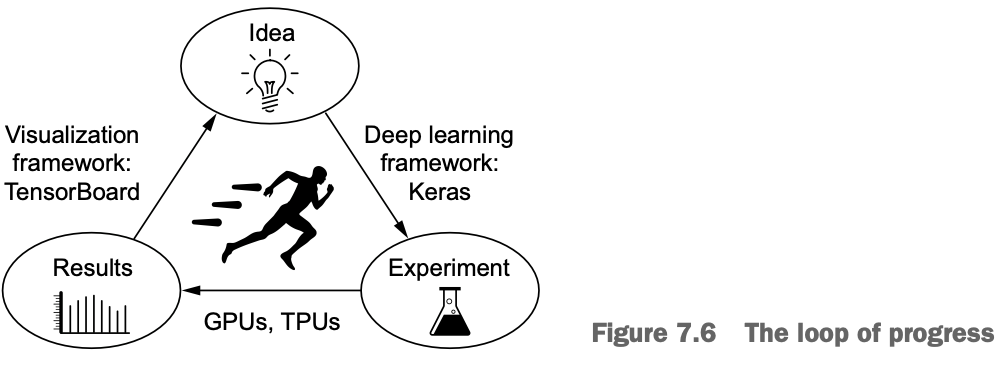

TensorBoard是一个基于浏览器的应用程序，您可以在本地运行。这是在训练期间监控模型内发生的一切的最佳方式。使用TensorBoard，您可以

- 可视化监督训练期间的指标
- 可视化模型结构
- 可视化激活和梯度的柱状图
- 探索 3D 嵌入

如果您正在监控的信息，而不仅仅是模型的最终损失，您可以对模型的作用和不做什么形成更清晰的愿景，并且您可以更快地取得进展。

将TensorBoard与Keras模型和 `fit()` 方法一起使用的最简单方法是使用 `keras.callbacks.TensorBoard` 回调。

在最简单的情况下，只需指定您希望回调编写日志的位置，您就可以走了：

In [ ]:
model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
tensorboard = keras.callbacks.TensorBoard(
    log_dir='./logs',
)
model.fit(train_images, train_labels,
          epochs=2,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

一旦模型开始运行，它将在目标位置编写日志。如果您在本地计算机上运行Python脚本，您可以使用以下命令启动本地 Tensor Board 服务器（请注意，如果您通过pip安装了TensorFlow，tensorboard 可执行文件应该已经可用；如果没有，您可以通过 `pip install tensorboard` 手动安装 TensorBoard）：

```
tensorboard --logdir /full_path_to_your_log_dir
```

然后，您可以导航到命令返回的URL，以访问TensorBoard界面。

如果您在 Colab notebook中运行脚本，您可以使用以下命令在 notebook 中运行 embedded TensorBoard 实例：

```
%load_ext tensorboard
%tensorboard --logdir /full_path_to_your_log_dir%load_ext tensorboard
```

在TensorBoard界面中，您将能够监控训练和评估指标的实时图表（见图7.7）。

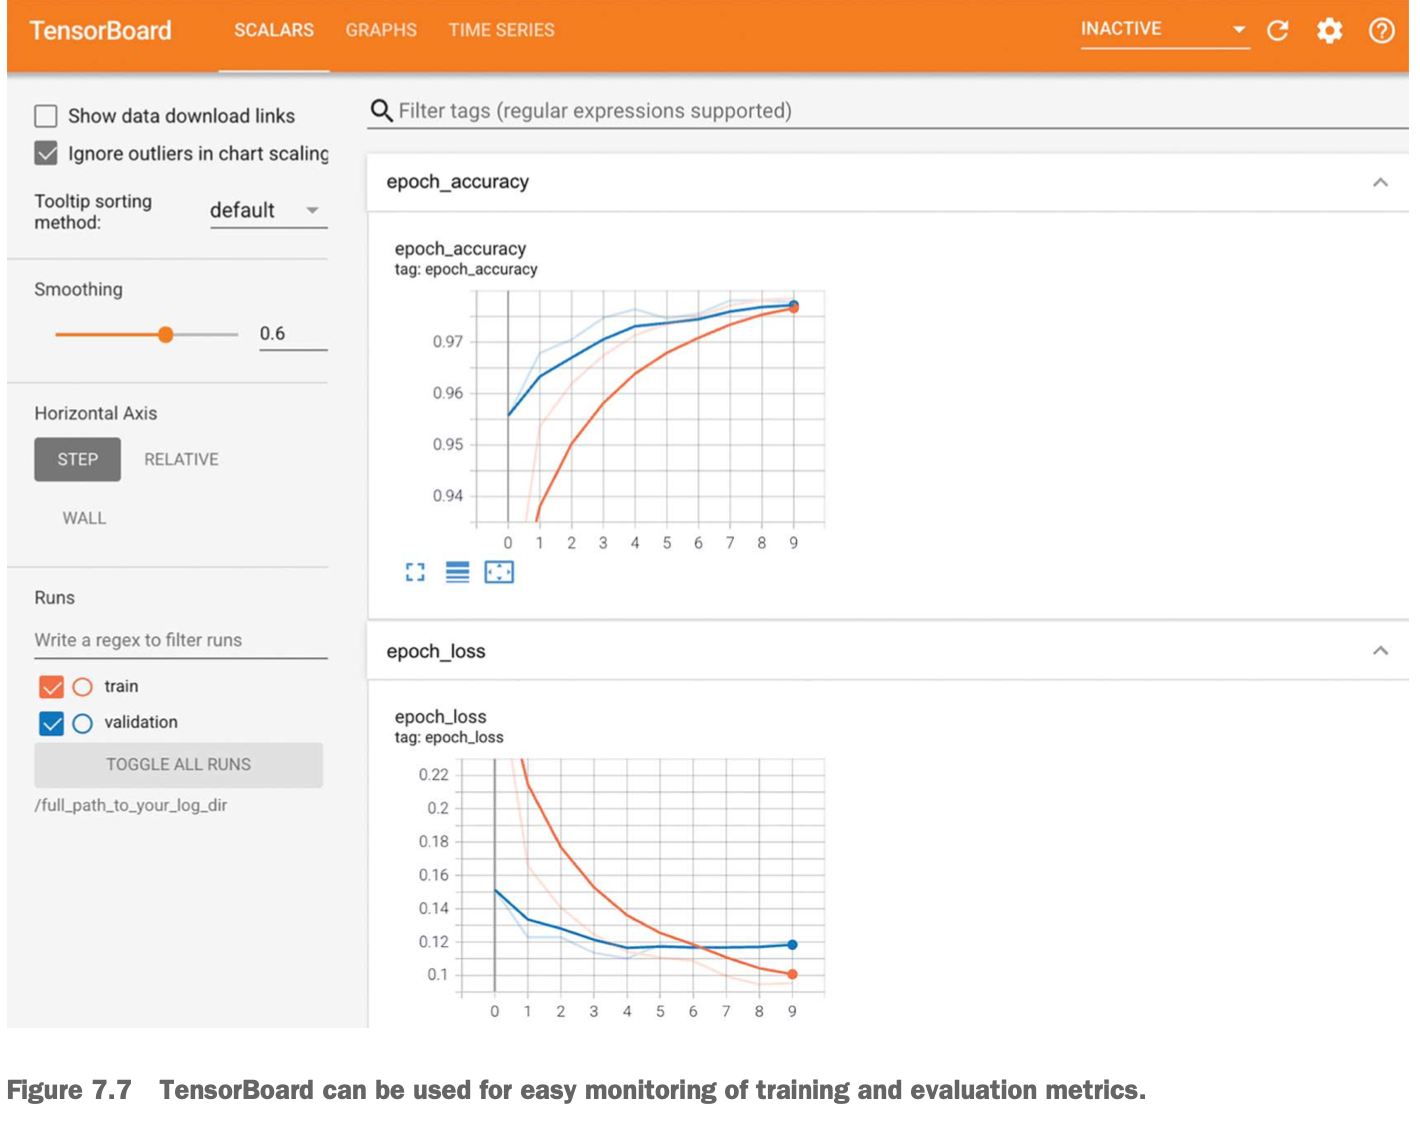

## 7.4 Writing your own training and evaluation loops

`fit()` 工作流程在易用性和灵活性之间达成了良好的平衡。这是你大部分时间都会用的东西。然而，它并不意味着支持深度学习研究人员可能想做的一切，即便可以自定义指标、自定义损失和自定义回调。

毕竟，内置的 `fit()` 工作流程只专注于监督学习：一种与输入数据关联的已知目标（也称为标签或注释）的设置，并且您将损失计算为这些目标和模型预测的函数。但是， 不是所有机器学习都是这种类型。还有其他没有明确目标的设置，如家生成学习（我们将在第12章中讨论）、自监督学习（从输入中获得目标）和强化学习（学习由“奖励”驱动，就像训练狗一样）。即使您正在进行常规的监督学习，作为一名研究人员，您可能也需要低阶的灵活性添加一些 novel bells 和 whistles。

每当您发现自己处于内置 `fit()` 不足的情况下，您都需要编写自己的自定义训练逻辑。您已经在第2章和第3章中看到了简单的样例——大量的低级训练循环。谨此提醒，典型训练循环的内容如下所示：

- 在 gradient tape 内运行前向传播（计算模型的输出），以获得当前一批数据的损失值。
- 检索与模型权重有关的损失的梯度。
- 更新模型的权重，以降低当前批次数据的损失值。

这些步骤会根据需要多次重复。这基本上就是 `fit()` 在引擎下做的事情。在本节中，您将学习从头开始重新实现 `fit()`，这将为您提供编写任何可能想出的训练算法所需的所有知识。

### 7.4.1 Training versus inference

在您迄今为止看到的低级训练循环示例中，第1步（前向传播）是通过 `predictions = model(inputs)` 完成的，第2步（检索 gradient tape 计算的梯度）是通过 `gradients = tape.gradient(loss，model.weights)` 完成的。在一般情况下，实际上你需要考虑两个微妙之处。

一些Keras层，如 `Dropout` 层，在 `training` 和 `inference` 期间（当您使用它们生成预测时）有不同的行为。这些层在其call()方法中暴露 `training` 布尔参数。调用 `dropout(inputs，training=True)` 将删除一些激活，而调用 `dropout(inputs，training=False)` 什么都不做。推而广之，Functional 和 Sequential 模型也在其 `call()` 方法中公开了此训练参数。在向前传播期间调用Keras模型时，请记住传入 `training=True` ！因此，我们的前向传播成为 `predictions=model(inputs，training=True)`。

此外，请注意，当您检索模型权重的梯度时，您不应该使用 `tape.gradients(loss, model.weights)`，而应该使用 `tape .gradients(loss, model.trainable_weights)`。事实上，layers 和 models 拥有两种权重：

- `Trainable weights` —— 这些旨在通过反向传播进行更新，以最大限度地减少模型的损失，例如 `Dense` 层的 kernel 和 bias。
- `Non-trainable weights` —— 这些应该在拥有它们的层的前向传播期间更新。例如，如果您希望自定义层保留迄今为止处理了多少批的计数器，该信息将存储在不可训练的权重中，并且在每批时，您的层将计数器增加一。

在Keras内置层中，唯一具有不可训练权重的层是 `BatchNormalization` 层，我们将在第9章中讨论。`BatchNormalization` 需要不可训练的权重，以跟踪有关通过该层的数据的平均值和标准偏差的信息，从而执行在线的特征规范化的近似（您在第6章中学到的概念）。

考虑到这两个细节，监督学习训练步骤最终是这样的：

```python
def traiin_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
        gradients = tape.gradients(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(model.trainable_weights, gradients))
```

### 7.4.2 Low-level usage of metrics


在低阶的训练循环中，您可能希望利用Keras指标（无论是自定义指标还是内置指标）。您已经了解了指标API：对每批目标和预测的简单调用 `update_state(y_true, y_pred)`，然后使用 result() 查询当前指标值：

In [ ]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result: .2f}")

您可能还需要跟踪标量值的平均值，例如模型的损失。您可以通过 `keras.metrics.Mean` 指标来做到这一点：

In [ ]:
values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

当您想重置当前结果时（在训练 epoch 开始或评估开始时），请记住使用 `metric.reset_state()` 。

### 7.4.3 A complete training and evaluation loop

让我们将前向传播、反向传播和指标跟踪合并到一个类似于 `fit()` 的训练步骤函数中，该函数会获取一批数据和目标，并返回 `fit()` 进度条显示的日志。

In [ ]:
model = get_mnist_model()

loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()
    
    loss_tracking_metric.update_state(loss)
    logs['loss'] = loss_tracking_metric.result()
    return logs

我们需要在每个 epoch 开始时和运行评估之前重置指标的状态。这里有一个实用工具功能可以做到这一点。

In [ ]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

我们现在可以列出完整的训练循环。请注意，我们使用 `tf.data.Dataset` 对象将我们的NumPy数据转换为迭代器，以32大小的批大小迭代数据。

In [ ]:
training_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}:{value: .4f}")

下面是评估循环：一个简单的循环，反复调用 `test_step()` 函数，该函数处理一批数据。`test_step()` 函数只是`train_step()` 逻辑的子集。它省略了处理更新模型权重的代码——即涉及 `GradientTape` 和优化器的所有内容。

In [50]:
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs['val_' + metric.name] = metric.result()
        
    loss_tracking_metric.update_state(loss)
    logs['val_loss'] = loss_tracking_metric.result()
    return logs

In [51]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}:{value:4f}")

Evaluation results:
...val_sparse_categorical_accuracy:0.960300
...val_loss:0.166997


恭喜你——你刚刚重新实现了 `fit()` 和 `evaluate()`！ 全部的 `fit()` 和 `evaluate()` 支持更多功能，包括大规模分布式计算，这需要更多的工作。它还包括几项关键的性能优化。

让我们看看以下优化之一：TensorFlow函数编译。

### 7.4.5 Leveraging fit() with a custom training loop

在前面的章节中，我们完全从头开始编写自己的训练循环。这样做为您提供了最大的灵活性，但最终您编写了大量代码，同时错过了`fit()` 的许多方便功能，例如回调或对分布式训练的内置支持。

如果您需要自定义训练算法，但仍然想利用内置Keras训练逻辑的力量，该怎么办？实际上，在 `fit()` 和从零开始编写的训练循环之间有一个中间立场：您可以提供自定义训练步骤功能，并让框架完成其余工作。

您可以通过重写 `Model` 类的 `train_step()` 方法来做到这一点。这是 `fit()` 为每批数据调用的函数。然后，您将能够像往常一样调用 `fit()` ，它将在引擎盖下运行您自己的学习算法。

下面是一个例子：

- 创建一个新的 subclass 类 `keras.Model`
- 重写方法 `train_step(self, data)`。 它的内容几乎和我们之前使用的几乎一致。 它返回字典映射 metric name(包括 loss) 以及它们当前的值。
- 实现 `metric` 属性， 其追踪模型的 `Metric` 实例。 这使得模型在每个epoch开始和 `evaluate` 开始时 自动调用 `reset_state()` 

In [58]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name='loss')

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
            gradients = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))
            
            loss_tracker.update_state(loss)
            return {'loss': loss_tracker.result()}
        
    @property
    def metrics(self):
        return [loss_tracker]

我们现在可以实例化我们的自定义模型，编译它（我们只传入优化器，因为损失已经在模型之外定义），并像往常一样使用 `fit()` 进行训练：

In [59]:
inputs = keras.Input(shape=(28*28, ))
features = layers.Dense(512, activation='relu')(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation='softmax')(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
   9/1563 [..............................] - ETA: 10s - loss: 1.7139 

2022-03-03 17:18:02.121186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 7s 4ms/step - loss: 0.2843
Epoch 2/3
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1565
Epoch 3/3
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1260


这里有几点注意：

- 此模式不妨碍您使用 Functional API 构建模型。无论您是构建 Sequential 模型、 Functional API模型还是子类模型，都可以做到这一点。
- 当您覆盖 `train_ step` 时，您不需要使用 `@tf.function` 装饰器——框架为您做到这一点。

现在，通过 `compile()` 的指标和配置损失呢？调用 `compile()`后，您可以访问以下内容：
- `self.compiled_loss` —— 传入 `compile()` 的损失函数
- `self.compiled_metrics` —— 您传递指标的列表的包装器，允许您调用`self.compiled_metrics.update_state()` 来更新一次你的所有指标。
- `self.metrics` —— 您传递给 `compile()` 的指标的实际列表。请注意，它还包括一个跟踪损失的指标，类似于我们之前手动使用 `loss_tracking_metric` 所做的。

In [ ]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name:m.result() for m in self.metrics}


In [65]:
inputs = keras.Input(shape=(28 * 28, ))
features = layers.Dense(512, activation='relu')(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation='softmax')(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
   1/1563 [..............................] - ETA: 7:02 - loss: 2.4908 - sparse_categorical_accuracy: 0.1875

2022-03-03 17:30:59.941475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 9s 6ms/step - loss: 0.2888 - sparse_categorical_accuracy: 0.9152
Epoch 2/3
1563/1563 [==============================] - 9s 5ms/step - loss: 0.1570 - sparse_categorical_accuracy: 0.9559
Epoch 3/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1301 - sparse_categorical_accuracy: 0.9644


# Summary

- Keras根据不断披露复杂性的原则，提供了一系列不同的工作流程，这些工作流程。它们都顺利地相互操作。
- 您可以通过Sequential类、Functional API或对Model类进行子类来构建模型。大多数时候，您将使用Functional API。
- 训练和评估模型的最简单方法是使用默认的 `fit()` 和 `evaluation()` 方法。
- Keras回调提供了一种简单的方法，可以在调用期间监控模型以 `fit()` ，并根据模型的状态自动采取行动。
- 您还可以通过重写 `train_ step()` 方法来完全控制 `fit()` 的作用。
- 除了 `fit()`，您还可以完全从头开始编写自己的训练循环。这对实施全新训练算法的研究人员很有用。